# Natural Language Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# LOAD DATA
#df = pd.read_csv('../../data/raw_home_automation.csv', sep=',')
df = pd.read_csv('../../data/raw_car_dashboard.csv', sep=',')

## Check the Quality of data for training

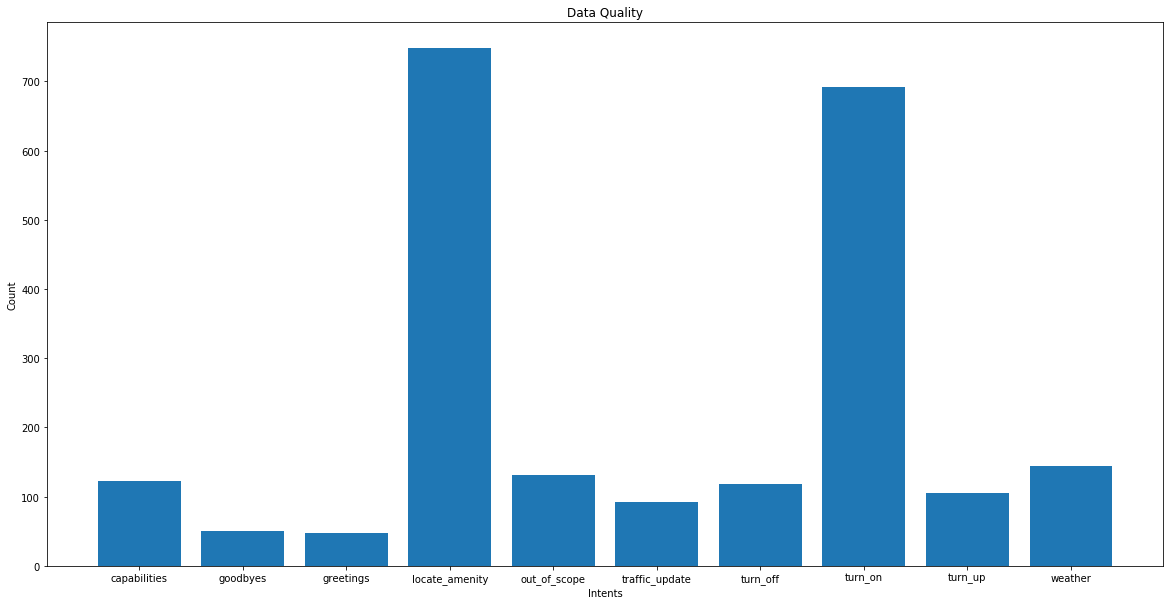

In [3]:
# df_quality_counts.plot()
# print(df_quality_counts.keys())
# print(df_quality_counts.values)
# df_quality_counts = df['intent'].value_counts().to_frame()
# df_quality_counts.rename(columns={'intent': 'value_counts'}, inplace=True)
# df_quality_counts.index.name = 'intent'
# print(df_quality_counts)
# print(df_quality_counts["value_counts"].unique())

# df_quality_counts = df['intent'].value_counts()
# df_quality_counts
df_quality_counts = df['intent'].value_counts().head(10)
plt.figure(figsize=(20,10))
plt.title("Data Quality")
# plt.ylim()
plt.xlabel("Intents")
plt.ylabel("Count")
plt.bar(df_quality_counts.keys(), df_quality_counts.values)
plt.show()  

In [4]:
X_train = df['utterances']
Y_train = df['intent']
X_test = pd.Series(["turn on the living room tubelight", "how is the weather in Bangalore"])
Y_test = pd.Series(["turn_on", "weather"])

## Using Scikit Learn for Classification

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(188, 245)
(188, 245)


In [6]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)
print("\n\nPrediction using MultinomialNB: >> ", clf.predict(count_vect.transform(X_test)))



Prediction using MultinomialNB: >>  ['appliance_action' 'weather']


## Using Tensorflow and Keras for Classification

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from tf.keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D
# from tf.keras.layers.core import Dropout
from keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from bs4 import BeautifulSoup

# from keras.layers import Embedding
# from keras.layers import Dense, Input, Flatten
# from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
# from keras.models import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
REMOTE = False
MODEL_PATH = "results/nlc_car_model.h5"
MODEL_WEIGHTS_PATH = "results/nlc_car_weights.hdf5"
!mkdir results

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1

mkdir: results: File exists


In [24]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
#     string = re.sub(r"\\", "", string)
#     string = re.sub(r"\'", "", string)
#     string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [25]:
texts = []
labels = []
# output_empty = [0] * len(df["intent"])
labels_index = {}
for i in range(len(df)):
    text = BeautifulSoup(df["utterances"][i], "lxml")
    texts.append(clean_str(text.get_text()))
    label_id = len(labels_index)
    labels_index[df["intent"][i]] = label_id
    labels.append(label_id)


In [26]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [27]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 258 unique tokens.


In [28]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (188, 1000)
Shape of label tensor: (188, 13)


In [30]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(170, 1000)
(170, 13)
(18, 1000)
(18, 13)


In [32]:
K.clear_session()
# tf.global_variables_initializer()
tf.reset_default_graph()

model = Sequential()
# model.add(Dense(output_dim=8,init ='uniform',activation='relu', input_dim=len(train_x[0])))
model.add(Dense(8, activation='relu', input_shape=(x_train.shape[1], )))
# model.add(Dense(8, activation='relu', input_dim=(len(train_x))))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='keras_logs', write_graph=True)

# # model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHTS_PATH, verbose=0, save_best_only=True) # Save best model
model.fit(x_train, y_train, epochs=200, batch_size=8,  verbose=1, validation_split=0.1, callbacks=[tbCallBack, monitor, checkpointer])
model.load_weights(MODEL_WEIGHTS_PATH) # load weights from best model
scores = model.evaluate(x_val, y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
model.save(MODEL_PATH)
print("<<<<<<<< ML MODEL CREATED AND SAVED >>>>>>>>>>>\n\n")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 8008      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 13)                117       
Total params: 8,269
Trainable params: 8,269
Non-trainable params: 0
_________________________________________________________________
Train on 153 samples, validate on 17 samples
Epoch 1/200
153/153 [==============================] - 0s 2ms/step - loss: 2.6427 - acc: 0.0458 - val_loss: 2.5082 - val_acc: 0.0588
Epoch 2/200
153/153 [==============================] - 0s 440us/step - loss: 2.5621 - acc: 0.0